In [18]:
import pandas as pd
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cross_validation

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [19]:
data=pd.read_csv('wine.data',header=None) #carga los datos del vino
data.columns = ['Class label', 'Alcohol','Malic acid', 'Ash','Alcalinity of ash', 'Magnesium','Total phenols', 'Flavanoids',
                'Nonflavanoid phenols','Proanthocyanins','Color intensity', 'Hue','OD280/OD315 of diluted wines','Proline'] 
#Diferentes características del vino

In [20]:
data.head() #Observación de primeros los datos del vino; Columnas son las características y filas son los distintos tipos de vinos

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [21]:
#Primero vamos a analizar la clasificación de vinos 
#Utilizando la reducción de dimensionalidad utilizando las características principales de los datos
#Para este propósito se utiliza el método PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#Para utilizar este método, los datos deben estar estandarizados 
standardsca = StandardScaler()
X_train_std = standardsca.fit_transform(X_train)
X_test_std = standardsca.transform(X_test)
#Para encontrar el número de caracterísiticas principales, se debe calcular la matríz de covarianza,
#autovalores y autovectores de los datos
mat_cov = np.cov(X_train_std.T)
auto_val, auto_vec = np.linalg.eig(mat_cov)

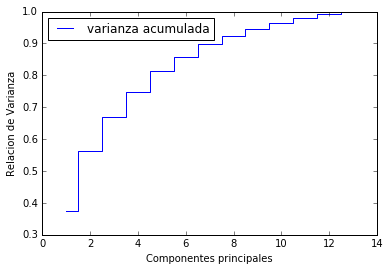

In [22]:
#Usando los autovectores, se calcula la varianza explicada cumulativa.
tot = sum(auto_val)
var_exp = [(i / tot) for i in sorted(auto_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.step(range(1,14), cum_var_exp, where='mid',label='varianza acumulada')
plt.ylabel('Relacion de Varianza')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

A partír del gráfico observamos que el número de componentes principales es DOS.
La suma porcentual de esta dos componentes es cercano al 60%.

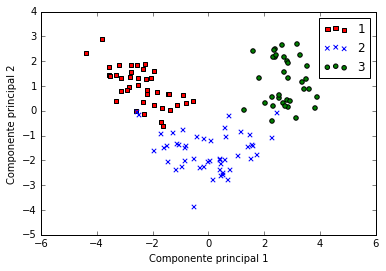

In [26]:
#Usando las dos componentes principales, se procede a utilizar el algorítmo PCA para bajar 
#Dimensionalidad y utilizarlo en Random Forest y Kmeans
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_train_std)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers): 
    plt.scatter(X_r[y_train==l, 0], X_r[y_train==l, 1],c=c, label=l, marker=m)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend()
plt.show()

In [27]:
#Habiendo obtenido las componentes principales del problema, se utilizarán en Kmeans
#para primero obtener el números de clusters necesarios para clasificar los datos.
X, y = data.iloc[:, 1:].values, (data.iloc[:, 0].values-1)
pca = PCA(n_components=2, whiten=True).fit(X)
X_pca = pca.transform(X)

[356.00000000000028, 221.59356353887878, 119.54764565923628, 92.866926774097962, 77.360356759768479, 65.817967581942838, 58.151214031312094, 49.077423275662497, 41.960563264927686, 37.521869200430316]


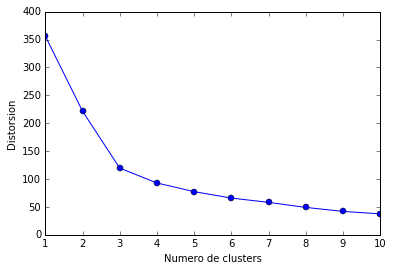

In [28]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#La forma de obtener el número correcto de clusters, es a través del método
# de "Elbow". Cuando aparece el codo en la figura calculada de la siguiente
# forma, este es el número de clusters a escoger
distorsiones = []
for i in range(1, 11):
    km=KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(X_pca)
    distorsiones.append(km.inertia_)
    
print(distorsiones)    
    
plt.plot(range(1,11), distorsiones, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Distorsion')
plt.show()

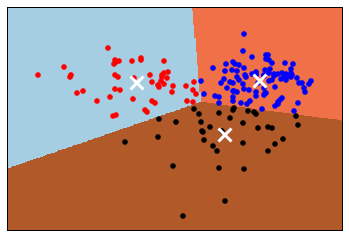

In [29]:
#De la figura anterior, se observa que el número total de clusters a escoger
#para los datos del vino son 3. Esto va de acuerdo a las diferentes clases 
#dadas por el repositorio de datos.
kmeans=KMeans(n_clusters=3)
kmeans.fit(X_pca)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_ 
 

x_min, x_max = X_pca[:, 0].min()-0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min()-0.5, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')
colors=["r.","b.","k."]
for i in range(len(X_pca)):
    plt.plot(X_pca[i][0], X_pca[i][1],colors[labels[i]],markersize=10)
    
centroids = kmeans.cluster_centers_
inert = kmeans.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=8)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

En la anterior gráfica se observa las diferentes regiones en las que los 
nuevos datos pueden ser clasificados. Se obseva el centroide para cada uno
de los nuevos datos y las regiones de decisión.

RANDOM FORESTS

Primero queremos encontrar el número de árboles aleatorios óptimo
para este propósito utilizamos el oob error http://scikit-learn.org/stable/modules/ensemble.html

In [32]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

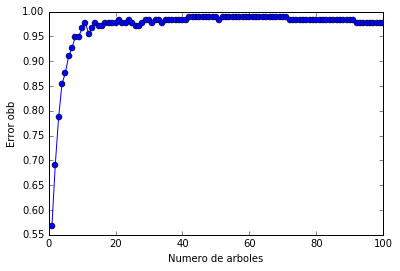

In [33]:
n_estimators = 100
forest = RandomForestClassifier(warm_start=True, oob_score=True)
obb=[]

for i in range(1, n_estimators + 1):
        forest.set_params(n_estimators=i)
        forest.fit(X, y)
        oob_error = 1-forest.oob_score_
        obb.append(forest.oob_score_)

plt.plot(range(1,101), obb, marker='o')
plt.xlabel('Numero de arboles')
plt.ylabel('Error obb')
plt.show()

Se observa que se obtiene una saturación antes de los 20 árboles, para esto hagamos un zoom.

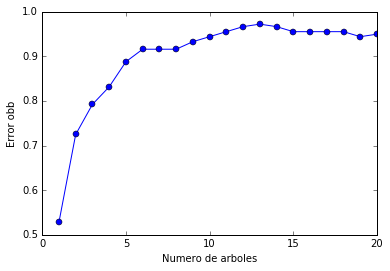

In [34]:
n_estimators = 20
forest = RandomForestClassifier(warm_start=True, oob_score=True)
obb=[]

for i in range(1, n_estimators + 1):
        forest.set_params(n_estimators=i)
        forest.fit(X, y)
        oob_error = 1-forest.oob_score_
        obb.append(forest.oob_score_)

plt.plot(range(1,21), obb, marker='o')
plt.xlabel('Numero de arboles')
plt.ylabel('Error oob')
plt.show()

Del anterior gráfico, se observa que el número óptimo de árboles para los vinos es igual 13.

Random Forests, es un clasificador de gran versalitidad, además con la el recurso de PCA se mejora el rendimiento
de la clasificación. 